In [1]:
import numpy as np
import random
import time
import sklearn
import sklearn.metrics
tol = 10^-8

In [2]:
def kernel_expo(x,y,gamma):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

In [81]:
def KKTviol(O,rho,mu,l,alpha,ens):
    #ens = list(ens)
    #random.shuffle(ens)
    ens2 = np.where(np.logical_or((rho-O[ens])*(1/(mu*l)-alpha[ens])>0, (O[ens]-rho)*alpha[ens]>0))
    #for index in ens:
    #    if (O[index] -rho)*alpha[index]>0 or (rho-O[index])*(1/(mu*l)-alpha[index])>0:
    #        #print((O[index] -rho)*alpha[index],(rho-O[index])*(1/(mu*l)-alpha[index]),alpha[index])
    #        return index
    if len(ens2[0]) == 0:
        return -1
    else :
        index = np.random.randint(len(ens2[0]))
        return ens2[0][index]
    #return -1

In [82]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    Oens = O[ens]
    return ens[np.argmax(O[i]-Oens)]

In [83]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            #print("sur les bords",K[i,i]+K[j,j]-2*K[i,j],xmin)
            #time.sleep(1)
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            #print("A l'intérieur",xmin)
            #time.sleep(1)
            alphaj = xmin
            alphai = delta - alphaj
        """
        alphaj = alpha[j] + (O[i]-O[j])/(K[i,i]+K[j,j]-2*K[i,j])
        if alphaj < 0:
            alphaj = 0
        if alphaj >1/(l*mu):
            #print("l",l,mu)
            alphaj = 1/(l*mu)
        delta = alpha[i]+alpha[j]
        alphai = delta - alphaj
        """
    alphai = delta - alphaj
    #print(alphai,alphaj)
    #print("alphai , alphaj : ",alphai,alphaj,alpha[i],alpha[j] , " delta : ", delta)
    if alpha[i]+alpha[j] - (alphai + alphaj)>10**(-8):
        print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
        print(alpha[i],alpha[j],alphai,alphaj)
    if alphai<0 or alphaj <0 or alphai >1/(mu*l) or alphaj >1/(mu*l):
        print("oups",alphai,alphaj)
    return alphai,alphaj
    

In [84]:
def SVcalc(alpha,c):
    return list(np.where((alpha>0))[0])#&(alpha<c))[0])

In [85]:
class osvm:
    def __init__(self,mu=0.01,maxiter=2500,eps=0.001,gamma=5):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        self.gamma = gamma
        
    def fit(self,data):
        print("Initialisation")
        self.alpha = np.zeros(np.shape(data)[0])
        self.l = np.shape(data)[0] 
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,self.gamma) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(l*self.mu)
            s += 1/(l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            #print(1-s)
            s = 1
        #C = np.dot(self.alpha[2:],K[2:,:])
        O = np.dot(self.alpha,K)
        self.rho = max(O[self.alpha>0])
        #print(sum(self.alpha))
        print("Apprentissage")
        iter_etape = 0
        iteration = 0
        while iteration < self.maxiter:
            
            # Etape (i)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,range(l))
            if index == -1:
                break
            iteration += 1
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            """if SV == []:
                SV_rand = np.random.randint(len(self.alpha))
                while SV_rand == index:
                    SV_rand = np.random.randint(len(self.alpha))
                SV = [SV_rand]"""
            if SV == []:
                print("SV empty")
                continue
            j = argmax(O,index,SV)
            #print("before",self.alpha[index],self.alpha[j])
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            #print("after",self.alpha[index],self.alpha[j])
            
            # update de rho
            O = np.dot(self.alpha,K)
            self.rho = min(O[(self.alpha>0) & (self.alpha< 1/(self.mu*l))])
            
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            # Etape (ii)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            maxiterii = 100
            iterii = 0
            while index !=-1 and iterii < maxiterii and len(SV)>=1:
                iterii += 1
                iter_etape += 1
                while index in SV:
                    SV.remove(index)
                if SV != []:
                    j = argmax(O,index,SV)
                    #print("j " , j)
                    #time.sleep(0.5)
                    #print("before",self.alpha[index],self.alpha[j])
                    delta = self.alpha[index] + self.alpha[j]
                    #self.alpha[index],self.alpha[j] 
                    alphai , alphaj = optim(self.alpha,index,j,K,O,self.mu,l)
                    self.alpha[index] = alphai
                    self.alpha[j] = alphaj
                    if sum(self.alpha) > 1.001:
                        print("etape ii " ,sum(self.alpha))
                        print(self.alpha[index] + self.alpha[j] , delta, alphai + alphaj)
                        print(index,j)
                        print(SV)
                        time.sleep(0.5)
                    #print("after",self.alpha[index],self.alpha[j])
                    #time.sleep(0.5)
                    # update de rho
                    #print(np.size(self.alpha),np.size(K))
                    O = np.dot(self.alpha,K)
                    try:
                        self.rho = min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ])
                    except:        
                        break
                
                #print(index)
                SV = SVcalc(self.alpha,1/(self.mu*l))
                if len(SV) == 1:
                    break
                #print(" longueur sv " ,len(SV))
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                while index in SV:
                    SV.remove(index)
                
            if iterii == maxiterii :
                continue
                print("Boucle (ii) infinie")
                """
                rargmax = 0
                rmax = 0
                for i in range(len(self.alpha)):
                    alp = self.alpha[i]
                    if alp >0 and alp < 1*(self.mu*l):
                        print(O[i])
                        if O[i]> rmax:
                            rmax = O[i]
                            rargmax = i
                            """
                #print(min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]),max(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]))
                #print("sum : " , sum(self.alpha))
                print(self.rho)
                #print(self.rho,rargmax,O[rargmax],self.alpha[rargmax],rmax)

            if iteration%10 == 0 :
                print(iter_etape,iteration,self.maxiter,self.rho,np.dot(self.alpha,np.dot(self.alpha,K)))
                iter_etape = 0
                
        #return self.alpha,self.rho    
    
    def predict(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.sign(np.dot(self.alpha,K)-self.rho)
    
    def decision_function(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.dot(self.alpha,K)-self.rho

In [ ]:
test = osvm(0.01,gamma = 20)
data = 2*(-0.5 + np.random.rand(1000))
test.fit(data)

Initialisation
Apprentissage

In [29]:
# probleme de la projection de alpha1 et alpha2
#return alpha?
test.rho

0.29688625404304714

In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

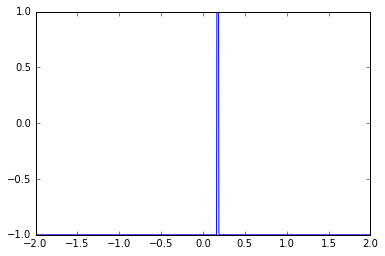

In [31]:
x=np.linspace(-2,2,1000)
y = test.predict(x)
plt.plot(x,y)

In [11]:
xtest=np.linspace(-1,1,1000)

In [24]:
nb = 0
for x in xtest:
    if test.predict(x)<0 :
        nb += 1


In [25]:
nb

7

In [18]:
124/1000

0.124

KeyboardInterrupt: 

In [59]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = osvm(0.01)
clf.fit(X_train)


2832 10 2500 0.26181859564 0.26181859564


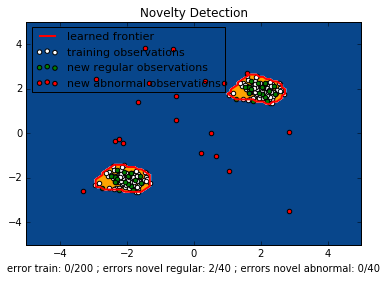

In [70]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [63]:
n_error_outliers

0